In [36]:
import sys
import xlrd
import pandas as pd
import numpy as np
from numpy import median
import os
import fnmatch 
import random
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly
import plotly.graph_objects as go
import plotly.express as px
from scipy import stats
import statistics
from scipy import signal
from scipy import optimize
import math
from sklearn.linear_model import LinearRegression

In [37]:
cwd = os.getcwd()
print(cwd)
# Ribosome counts directory
#Ribocsv_dir = cwd+'/output/Glu_readd/EY-Ribo/'
Ribocsv_dir = cwd+'/output/Anna/'
# Polarity directory
polcsv_dir = cwd+'/outputcsv/Anna/'
#polcsv_dir = cwd+'/outputcsv/Glu_readd/EY-Ribo/'
# mRNA counts directory
RNAcsv_dir = cwd+'/output/Glu_readd/EY-RNA/'
# Delta Dhh1 file
dhh1file = cwd+'/Dhh1_Length_Short.xlsx'
tag = 'longmers_deduplicated_sorted_aligned_coding_NI-'
rna_tag = tag
#tag = 'Ribo'
#rna_tag = 'RNA'
# Define range of calculation samples and labels in bp
viewer = 1000*3
names = ['811','813', '815','817']
labels = ['logphase', '-Glu01','-Glu05', '-Glu15']
#names = ['15','7516','1517', '15118','15529']
names_r = ['24','7525','1526','15127','15511']
#labels = ['logphase', '-Glu075','-Glu15', '-Glu15+Glu1','-Glu15+Glu5']

#names = ['15','7516','1517']
#labels = ['logphase', '-Glucose 7.5min','-Glucose 15min']

# Range of genes: length in bp
d1 = 0
d2 = 7654321
# avgerage and number of codons to aggregate
# if avgerage is False, we do not avgerage(for sparse data)
avg = True
#num_cs = [10,11,12,13,14,15,16,17,18,19,20,22]
#num_cs = [10,15,20,25,30,35]
num_cs = [15]
# Dhh1 tag all, enriched, depleted
dhh1_tag = 'all'


df_samples_readd = pd.DataFrame()
df_samples_stress = pd.DataFrame()
stress = []
readd = []

/Users/jingxiaozhang/Desktop/elongation


In [38]:
## Load data and find concensus genes in length range
red = ['YLL026W', 'YDR258C', 'YPL240C', 'YBR169C', 'YER103W', 
       'YGR142W', 'YDR171W', 'YCR021C', 'YBR072W', 'YFL014W', 'YLR327C']
isred = []
df_dhh1_all = pd.read_excel(dhh1file)
df_dhh1_all = df_dhh1_all.set_index('Name')
namelist = df_dhh1_all.index
Ribocsv_list_s=[]
RNAcsv_list_s = []
for root,dirs,files in os.walk(Ribocsv_dir):
    for n in names:
        for file in files: 
            time = ''
            if file.split('.')[-1] == "csv" and tag in file:
                time = ''.join(filter(lambda i: i.isdigit(), file.split('/')[-1].split(tag)[1].split('.csv')[0])) 
            if time == n:
                print(time)
                Ribocsv_list_s.append(Ribocsv_dir + file)
                dfribo = pd.read_csv(Ribocsv_dir + file)
                d2 = min(d2, max(dfribo.Length))
                dfribo = dfribo[(dfribo.Length >= d1)&(dfribo.Length <= d2)]
                reads_dict = dfribo.groupby(['Name']).agg({'Counts': np.sum,'Length':np.mean})
                reads_dict['CodonCoverage'] = reads_dict['Counts']/reads_dict['Length']*3
                
                if time == '811':
                    spread_cc = reads_dict['CodonCoverage'].quantile([0.05,0.25,0.5,0.75,0.95])
                    print(spread_cc)
                    reads_dict = reads_dict[reads_dict.CodonCoverage >= spread_cc.get(key=0.75)]
                namelist = list(set(namelist) & set(reads_dict.index))
                #print(len(reads_dict))
                #dfribo = dfribo[(dfribo.Name.isin(reads_dict.index))]

for root,dirs,files in os.walk(RNAcsv_dir):
    for n in names_r:
        for file in files: 
            time = ''
            if file.split('.')[-1] == "csv" and rna_tag in file:
                time = ''.join(filter(lambda i: i.isdigit(), file.split(rna_tag)[1].split('.csv')[0])) 
            if time == n:
                print(time)
                RNAcsv_list_s.append(RNAcsv_dir + file)
print('all files to measure in ' + Ribocsv_dir + ' is ',len(Ribocsv_list_s))
print('all files to measure in ' + RNAcsv_dir + ' is ',len(RNAcsv_list_s))
print('Number of genes ', len(df_dhh1_all))
print('Number of well translated genes ', len(namelist))

811
0.05    0.007189
0.25    0.041590
0.50    0.107547
0.75    0.318158
0.95    3.208384
Name: CodonCoverage, dtype: float64
813
815
817
all files to measure in /Users/jingxiaozhang/Desktop/elongation/output/Anna/ is  4
all files to measure in /Users/jingxiaozhang/Desktop/elongation/output/Glu_readd/EY-RNA/ is  0
Number of genes  4321
Number of well translated genes  715


In [39]:
df_dhh1 = df_dhh1_all[df_dhh1_all.index.isin(namelist)] 
#df_dhh1.to_csv(cwd+'/Dhh1_Length_Short_well_trans.xlsx')
print('total number of genes: ', len(df_dhh1))
spread_dhh1 = df_dhh1.Delta_Dhh1.quantile([0.25,0.5,0.65,0.75])
print(spread_dhh1)
low = spread_dhh1.get(key=0.25)
med = spread_dhh1.get(key=0.5)
high = spread_dhh1.get(key=0.75)

dhh1_enrich = df_dhh1[(df_dhh1.Delta_Dhh1 > med)]
dhh1_deplet = df_dhh1[(df_dhh1.Delta_Dhh1 < med)]
#dhh1_all = df_dhh1[(df_dhh1.Delta_Dhh1 > low)&(df_dhh1.Delta_Dhh1 < high)]
dhh1_all = df_dhh1
print('dhh1 enriched genes(-G-+G) ',len(dhh1_enrich))
print('dhh1 depleted genes(-G-+G) ',len(dhh1_deplet))
print('dhh1 all genes(-G-+G) ',len(dhh1_all))

if dhh1_tag == 'enriched':
    namelist = dhh1_enrich.index.tolist()
if dhh1_tag == 'depleted':
    namelist = dhh1_deplet.index.tolist()
if dhh1_tag == 'all':
    namelist = df_dhh1.index.tolist()

print(dhh1_tag, len(namelist))

total number of genes:  715
0.25   -0.468498
0.50    0.136986
0.65    0.484270
0.75    0.696426
Name: Delta_Dhh1, dtype: float64
dhh1 enriched genes(-G-+G)  357
dhh1 depleted genes(-G-+G)  357
dhh1 all genes(-G-+G)  715
all 715


In [40]:
def update_df(sample_agg_dict,df_samples,sample_time):
    temp_df = pd.DataFrame.from_dict(data = {'codon': list(sample_agg_dict.keys()), sample_time: list(sample_agg_dict.values())})
    temp_df = temp_df.set_index('codon')
    if len(df_samples) == 0: 
        df_samples = temp_df  
    else:
        #print(df_samples.columns)
        df_samples = pd.merge(df_samples, temp_df, left_index=True, right_index=True)
    
    return df_samples
def agg_codon(viewer,sample_rbf_dict,sample_label,i,num_c):
    global df_samples_readd,df_samples_stress,stress,readd
    # Smooth by codon sliding window
    reads = 0
    num_pos  = 0
    agg_dict = dict()
    for c in range(viewer):
        if c in sample_rbf_dict.index:
            left_c = max(1,c - int(num_c*3/2))
            right_c = c + int(num_c*3/2) + 1
            reads = sample_rbf_dict.loc[left_c:right_c,'NormCountsbp'].mean(axis=0) 
            agg_dict.update({c/3:reads})
            reads = 0
    # avg reads normalized ribosome reads per bp(not smoothed with codon window).
    '''
    countsbp = np.array(list(agg_dict.values()))
    sample_std = np.std(countsbp)
    sample_mean = np.mean(countsbp)
    sample_var = sample_std/sample_mean
    counts_distribution = np.quantile(countsbp,[0.05,0.25,0.5,0.75,0.95])
    '''
    if '+Glu' in sample_label: 
        df_samples_readd = update_df(agg_dict,df_samples_readd,sample_label)
        readd.append(sample_label)
    elif '-Glu15' in sample_label:
        df_samples_stress = update_df(agg_dict,df_samples_stress,sample_label)
        stress.append(sample_label)
        df_samples_readd = update_df(agg_dict,df_samples_readd,sample_label)
        readd.append(sample_label)
    else:
        df_samples_stress = update_df(agg_dict,df_samples_stress,sample_label)
        stress.append(sample_label)
        
    #return counts_distribution,sample_std,sample_var
        

In [41]:
def find_peak(index_list,increase_num):
    first_index = -10
    for j in range(len(index_list)):
        if index_list[j+int(increase_num*0.5)] > index_list[j] + increase_num:
            first_index = index_list[j]
            print("first peak by cd is ",(first_index+startbp)/3)
            break
    return first_index


def estimate_runoff_by_peak(all_sample_l,i,ref_i,peaks,increase_num):
    global time_course, select_times,startbp,endbp
    index_list = all_sample_l[i]
    t = select_times[i]
    t_insec = time_course[i]
    ref_peak = peaks[ref_i]
    prev_peak = peaks[i-1]
    ref = max(prev_peak,ref_peak)
    first_index = -10
    for j in range(len(index_list)):
        if index_list[j+int(increase_num*0.5)] <= index_list[j] + increase_num and index_list[j]>ref:
            first_index = index_list[j]
            print("new peak by cd is ",(first_index+startbp)/3)
            break
    return (first_index-ref)/t_insec/3,first_index

def estimate_runoff_by_shift(all_sample_l,i,ref_i,peaks,err):
    global time_course,select_times,startbp,endbp
    t = select_times[i]
    t_insec = time_course[i]-time_course[ref_i]
    alt_list = all_sample_l[i]
    ref_list = all_sample_l[ref_i]
    alt_peak = peaks[i]
    ref_peak = peaks[ref_i]
    shifts = []
    exclude = 0
    for j in range(ref_peak+1):
        k_ini = j+1
        ref_val = ref_list[j]
        for k in range(k_ini,alt_peak+1):
            alt_val = alt_list[k]
            if abs(alt_val-ref_val) <= err and alt_val <= ref_val:
                if exclude == 0:
                    exclude = k
                shifts.append(k-j)
                break
    return sum(shifts)/len(shifts)/t_insec/3,exclude


In [42]:
x = [0,5,15]
time_course = [0,1*60, 5*60, 15*60]
#x = [7.5,15]
#time_course = [0,7.5*60, 15*60]
num_c_shift_est_list = []
num_c_peak_est_list = []
for num_c in num_cs:
    times = []
    df_samples_readd = pd.DataFrame()
    df_samples_stress = pd.DataFrame()
    stress = []
    readd = []
    shift_est_list = []
    peak_est_list = []
    peaks = []
    #peaks = [184]
    el_r_peaks = []
    el_r_shifts = []
    lengthdict = {}
    startbp = 0
    endbp = 1500
    for i in range(len(Ribocsv_list_s)):
        ribofile = Ribocsv_list_s[i]
        time = ''.join(filter(lambda i: i.isdigit(), ribofile.split('/')[-1].split('.csv')[0])) 
        label = labels[names.index(time)]
        #print(label)
        times.append(label)
        dfribo = pd.read_csv(ribofile)
        dfribo = dfribo[(dfribo.Name.isin(namelist))]
        
        sf_dict = dfribo.groupby(['RelativePosition']).agg({"Counts": np.sum, "Name": pd.Series.nunique})
        #sf = 1
        sf = sf_dict[(sf_dict.index >= 800)&(sf_dict.index <= 1500)].Counts.mean(axis=0)
        #print(sf)
        dfribo['Counts'] = dfribo['Counts']/sf
        '''
        if len(RNAcsv_list_s) > 0:
            rnafile = RNAcsv_list_s[i]
            dfrna = pd.read_csv(rnafile)
            dfrna = dfrna[(dfrna.Name.isin(namelist))]
            dfribo = dfribo[(dfribo.Name.isin(dfrna.Name))]
            
            mrna_dict = dfrna.groupby('Name').agg({'Counts': np.sum,'Length': np.mean})
            totalmrna = sum(mrna_dict['Counts'])
            mrna_dict['mRNALevel'] = mrna_dict['Counts']/mrna_dict['Length']/totalmrna
            sf_rna = mrna_dict['mRNALevel'].median(axis=0)
            ribos = []
            for k in range(len(dfribo)):
                name = dfribo.iloc[k,0]
                count = dfribo.iloc[k,-1]
                normcount = count/(mrna_dict.loc[name,'mRNALevel']/sf_rna)
                ribos.append(normcount)
            #dfribo['NormCounts'] = ribos 
        '''
        reads_dict = dfribo.groupby(['Name']).agg({"Counts": np.sum,'RelativePosition':pd.Series.nunique})
        reads_dict['ReadDensity'] = reads_dict['Counts']/reads_dict['RelativePosition']

        ribos = []
        for k in range(len(dfribo)):
            name = dfribo.iloc[k,0]
            count = dfribo.iloc[k,-1]
            normcount = count/reads_dict.loc[name,'ReadDensity']
            ribos.append(normcount)
            
        dfribo['NormCounts'] = ribos 
        rbf_dict = dfribo.groupby(['RelativePosition']).agg({"NormCounts": np.sum, "Name": pd.Series.nunique})
        rbf_dict['NormCountsbp'] = rbf_dict['NormCounts']/rbf_dict['Name']
        #print('In sample ', label, ' median of averaged read ', reads_dict['ReadDensity'].median(axis=0))
        #print('In sample ', label, ' number of positions covered ', len(rbf_dict))
        agg_codon(viewer,rbf_dict,label,i,num_c)
    
    df_samples = df_samples_stress
    df_samples['pseudoref'] = stats.gmean(df_samples.loc[:,times],axis=1)
    for t in times:  
        ratio = df_samples[t]/df_samples['pseudoref']
        norm_r = statistics.median(ratio)
        normed = list(df_samples[t]/norm_r)
        df_samples[t] = normed
    df_samples = df_samples.drop(columns=['pseudoref'])
    select_times = df_samples.columns[-4:]
    df_samples_all = df_samples.loc[:,select_times]
    #print(select_times)
    #print(df_samples_all.index)

    df_samples_all = df_samples_all[(df_samples_all.index>=math.ceil(startbp/3))&(df_samples_all.index<=int(endbp/3))]
    for i in range(len(select_times)):
        t = select_times[i]
        fit_y = df_samples_all[t]
        shift_est_list.append(list(fit_y))
        t_prev = select_times[0]
        
        if i == 0:
            fit_y = list(df_samples_all[t_prev])
            l = fit_y[startbp:endbp]
            index_list = [idx for idx, val in enumerate(l[1:]) if val >= l[idx-1]]
            first_peak = find_peak(index_list,increase_num=20)
            peaks.append(first_peak)
            peak_est_list.append(index_list)
        else:
            fit_y = list(df_samples_all[t]-df_samples_all[t_prev])
            l = fit_y[startbp:endbp]
            index_list = [idx for idx, val in enumerate(l) if val >= 0]
            peak_est_list.append(index_list)
               
    for i in range(1,len(select_times)):
        el_r_peak,peak = estimate_runoff_by_peak(peak_est_list,i,0,peaks,increase_num=20)
        peaks.append(peak)
        el_r_peaks.append(el_r_peak)
        el_r_shift,exc = estimate_runoff_by_shift(shift_est_list,i,0,peaks,0.01)
        #excs.append(exc)
        #ref_p = peak
        el_r_shifts.append(el_r_shift)
        print('peak est.elong is '+str(el_r_peak)+'aa/sec')
        print('shift est.elong is '+str(el_r_shift)+'aa/sec')
    num_c_shift_est_list.append(el_r_shifts)
    num_c_peak_est_list.append(el_r_peaks)
        

first peak by cd is  26.333333333333332
new peak by cd is  154.66666666666666
peak est.elong is 2.138888888888889aa/sec
shift est.elong is 0.86aa/sec
new peak by cd is  221.33333333333334
peak est.elong is 0.2222222222222222aa/sec
shift est.elong is 0.13806944444444444aa/sec
new peak by cd is  331.0
peak est.elong is 0.12185185185185186aa/sec
shift est.elong is 0.01828879512423816aa/sec


In [43]:
#colors = ['blue','green','red','violet','purple']
fig = go.Figure()
shift_est_list = []
meds = []
rng = d1
prev_peak = 0
el_y = 0
el_x = []
peaks = []
rates = []
for i in range(len(select_times)):
    t = select_times[i]
    #t = times[i]+'_normed'
    fit_y = df_samples_all[t]
    fig.add_trace(go.Scatter(x=df_samples_all.index, y = fit_y,mode='lines',name= t.split('_')[0]))
    shift_est_list.append(list(fit_y)[startbp:endbp])
    print(len(list(fit_y)[startbp:endbp]))


fig.update_layout(
    template='simple_white',
    title_text="Normalized ribosome reads at codon position for " +dhh1_tag+ " genes between " + str(d1) + "bp and " + str(d2)+ "bp",
    #xaxis_title="Codon position(" + str(num_c) + " codons sliding window)",
    xaxis_title="Codon position",
    yaxis_title="Normalized ribosome reads"
)       

fig.update_xaxes(range=[math.ceil(startbp/3),int(endbp/3)])
#fig.update_xaxes(range=[math.ceil(startbp/3),410])
fig.update_yaxes(range=[0.52,1.22])

fig.show()

1500
1500
1500
1500


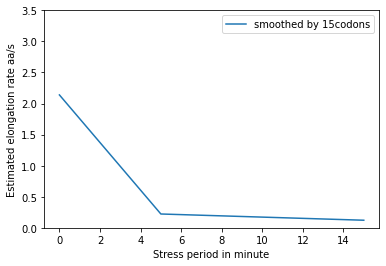

In [44]:
if dhh1_tag == 'enriched':
    el_r_peaks_e = el_r_peaks
if dhh1_tag == 'all':
    el_r_peaks_a = el_r_peaks
fig = plt.figure()
ax1 = plt.axes()
for i in range(len(num_cs)):
    el_r_peaks = num_c_peak_est_list[i]
    ax1.plot(x, el_r_peaks,label='smoothed by '+str(num_cs[i])+'codons')
#plt.ylim(0,0.5)
plt.ylim(0,3.5)
#plt.title("Peak estimated elongation rate in " +dhh1_tag+ " genes between " + str(d1) + "bp and " + str(d2)+ "bp")
plt.xlabel("Stress period in minute")
plt.ylabel("Estimated elongation rate aa/s")
plt.legend()
fig.savefig(cwd+'/Peakocc_estimated_elong_'+dhh1_tag+str(len(num_cs))+ '.png',dpi = 500)

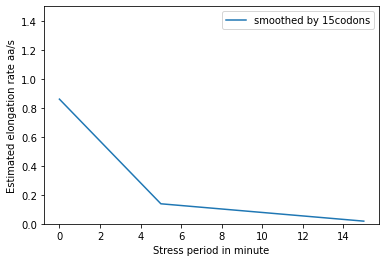

In [30]:
if dhh1_tag == 'enriched':
    el_r_shifts_e = el_r_shifts
if dhh1_tag == 'all':
    el_r_shifts_a = el_r_shifts
fig = plt.figure()
ax2 = plt.axes()
for i in range(len(num_cs)):
    el_r_shifts = num_c_shift_est_list[i]
    ax2.plot(x, el_r_shifts,label='smoothed by '+str(num_cs[i])+'codons')
plt.ylim(0,1.5)
#plt.title("Shift estimated elongation rate in " +dhh1_tag+ " genes between " + str(d1) + "bp and " + str(d2)+ "bp")
plt.xlabel("Stress period in minute")
plt.ylabel("Estimated elongation rate aa/s")
plt.legend()
fig.savefig(cwd+'/Shift_estimated_elong_'+dhh1_tag+str(len(num_cs))+ '.png',dpi = 500)

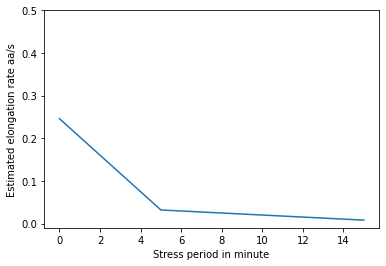

In [31]:
#el_r_driv = [0.31415,0.09287,0.02837]
#deplet=[0.15011236603852762,0.025800591777242653,0.011358060325129366]
enrich=[0.3270741076450854,0.042679441358542194,0.009367620983814865]
#all_g=[0.24620603772659397,0.029843308510438368,0.008467413591289736]
all_g=[0.2460340430325393,0.03184229493802222,0.008006282098149931]
el_r_driv_e = enrich
el_r_driv_a = all_g
if dhh1_tag == 'enriched':
    el_r_driv = el_r_driv_e
if dhh1_tag == 'all':
    el_r_driv = el_r_driv_a
fig = plt.figure()
ax2 = plt.axes()
for i in range(len(num_cs)):
    el_r_shifts = num_c_shift_est_list[i]
    ax2.plot(x, el_r_driv,label='smoothed by '+str(num_cs[i])+'codons')
    #ax2.plot(x, el_r_driv_e,label=)
plt.ylim(-0.01,0.5)
plt.xlabel("Stress period in minute")
plt.ylabel("Estimated elongation rate aa/s")
#plt.legend()
fig.savefig(cwd+'/Diriv_estimated_elong_'+dhh1_tag+ '.png',dpi = 500)

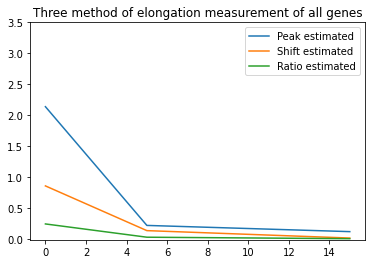

In [32]:
fig = plt.figure()
plt.plot(x, el_r_peaks,label='Peak estimated')
plt.plot(x, el_r_shifts,label='Shift estimated')
plt.plot(x, el_r_driv,label='Ratio estimated')
plt.ylim(-0.01,3.5)
plt.title("Three method of elongation measurement of "+dhh1_tag+" genes")
plt.legend()
fig.savefig(cwd+'/elong_est_comp_meth'+dhh1_tag+'.png',dpi = 500)

In [33]:
if dhh1_tag == 'all':
    fold_c_p_a = []
    fold_c_s_a = []
    fold_c_r_a = []
    for i in range(3):
        if i == 0:
            fold_c_p_a.append(el_r_peaks_a[0]/el_r_peaks_a[0])
            fold_c_s_a.append(el_r_shifts_a[0]/el_r_shifts_a[0])
            fold_c_r_a.append(el_r_driv_a[0]/el_r_driv_a[0])
        else:
            fold_c_p_a.append(el_r_peaks_a[i]/el_r_peaks_a[0])
            fold_c_s_a.append(el_r_shifts_a[i]/el_r_shifts_a[0])
            fold_c_r_a.append(el_r_driv_a[i]/el_r_driv_a[0])
if dhh1_tag == 'enriched':
    fold_c_p_e = []
    fold_c_s_e = []
    fold_c_r_e = []
    for i in range(3):
        if i == 0:
            fold_c_p_e.append(el_r_peaks_e[0]/el_r_peaks_e[0])
            fold_c_s_e.append(el_r_shifts_e[0]/el_r_shifts_e[0])
            fold_c_r_e.append(el_r_driv_e[0]/el_r_driv_e[0])
        else:
            fold_c_p_e.append(el_r_peaks_e[i]/el_r_peaks_e[0])
            fold_c_s_e.append(el_r_shifts_e[i]/el_r_shifts_e[0])
            fold_c_r_e.append(el_r_driv_e[i]/el_r_driv_e[0])
    

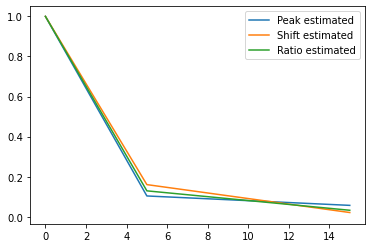

In [34]:
fig = plt.figure()
plt.plot(x, fold_c_p_a,label='Peak estimated')
plt.plot(x, fold_c_s_a,label='Shift estimated')
plt.plot(x, fold_c_r_a,label='Ratio estimated')
plt.legend()
plt.ylim(-0.035,1.05)
fig.savefig(cwd+'/elong_est_fold_comp_meth'+str('all')+'.png',dpi = 500)

In [35]:
fig = plt.figure()
plt.plot(x, fold_c_p_e,label='Peak estimated')
plt.plot(x, fold_c_s_e,label='Shift estimated')
plt.plot(x, fold_c_r_e,label='Ratio estimated')
plt.legend()
plt.ylim(-0.015,1.05)
fig.savefig(cwd+'/elong_est_fold_comp_meth'+dhh1_tag+'.png',dpi = 500)

NameError: name 'fold_c_p_e' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
colors = ['grey','black']
fig = plt.figure()
ax1 = plt.axes()
for i in range(len(num_cs)):
    el_r_peaks = num_c_peak_est_list[i]
    ax1.plot(x, el_r_peaks_a,label='All genes',color=colors[0])
    ax1.plot(x, el_r_peaks_e,label='Dhh1 enriched genes',color=colors[1])
plt.ylim(0,3.5)
plt.xlabel("Stress period in minute")
plt.ylabel("Estimated elongation rate aa/s")
plt.legend()
fig.savefig(cwd+'/Peakocc_estimated_elong_compdhh1.png',dpi = 500)

fig = plt.figure()
ax1 = plt.axes()
for i in range(len(num_cs)):
    el_r_peaks = num_c_peak_est_list[i]
    ax1.plot(x, el_r_shifts_a,label='All genes',color=colors[0])
    ax1.plot(x, el_r_shifts_e,label='Dhh1 enriched genes',color=colors[1])
plt.ylim(0,1.5)
plt.xlabel("Stress period in minute")
plt.ylabel("Estimated elongation rate aa/s")
plt.legend()
fig.savefig(cwd+'/Shiftocc_estimated_elong_compdhh1.png',dpi = 500)

fig = plt.figure()
ax1 = plt.axes()
for i in range(len(num_cs)):
    el_r_peaks = num_c_peak_est_list[i]
    ax1.plot(x, el_r_driv_a,label='All genes',color=colors[0])
    ax1.plot(x, el_r_driv_e,label='Dhh1 enriched genes',color=colors[1])
plt.ylim(-0.01,0.5)
plt.xlabel("Stress period in minute")
plt.ylabel("Estimated elongation rate aa/s")
plt.legend()
fig.savefig(cwd+'/Dirivocc_estimated_elong_compdhh1.png',dpi = 500)

In [ ]:
colors = ['grey','black']
fig = plt.figure()
ax1 = plt.axes()
for i in range(len(num_cs)):
    el_r_peaks = num_c_peak_est_list[i]
    ax1.plot(x, fold_c_p_a,label='All genes',color=colors[0])
    ax1.plot(x, fold_c_p_e,label='Dhh1 enriched genes',color=colors[1])
plt.ylim(0,1.05)
plt.xlabel("Stress period in minute")
plt.ylabel("Change in estimated elongation rate")
plt.legend()
fig.savefig(cwd+'/Peakocc_estimated_elong_compdhh1_fc.png',dpi = 500)

fig = plt.figure()
ax1 = plt.axes()
for i in range(len(num_cs)):
    el_r_peaks = num_c_peak_est_list[i]
    ax1.plot(x, fold_c_s_e,label='All genes',color=colors[0])
    ax1.plot(x, fold_c_s_a,label='Dhh1 enriched genes',color=colors[1])
plt.ylim(0,1.05)
plt.xlabel("Stress period in minute")
plt.ylabel("Change in estimated elongation rate")
plt.legend()
fig.savefig(cwd+'/Shiftocc_estimated_elong_compdhh1_fc.png',dpi = 500)

fig = plt.figure()
ax1 = plt.axes()
for i in range(len(num_cs)):
    el_r_peaks = num_c_peak_est_list[i]
    ax1.plot(x, fold_c_r_e,label='All genes',color=colors[0])
    ax1.plot(x, fold_c_r_a,label='Dhh1 enriched genes',color=colors[1])
plt.ylim(0,1.05)
plt.xlabel("Stress period in minute")
plt.ylabel("Change in estimated elongation rate")
plt.legend()
fig.savefig(cwd+'/Dirivocc_estimated_elong_compdhh1_fc.png',dpi = 500)

In [80]:
est_elongs = []
for i in range(len(select_times)-1):
    est_elong = []
    for j in range(len(num_cs)):
        est_elong.append(num_c_shift_est_list[j][i])
        est_elong.append(num_c_peak_est_list[j][i])
    est_elongs.append(est_elong)

if dhh1_tag == 'enriched':
    est_elongs_e = est_elongs
if dhh1_tag == 'all':
    est_elongs_a = est_elongs

In [81]:
df_a = pd.DataFrame(np.array(est_elongs_a).T,columns = select_times[1:])
df_e = pd.DataFrame(np.array(est_elongs_e).T,columns = select_times[1:])

In [92]:
df_e['fc_'+select_times[2]] = df_e[select_times[2]]/df_e[select_times[1]]
df_e['fc_'+select_times[3]] = df_e[select_times[3]]/df_e[select_times[1]]
df_a['fc_'+select_times[2]] = df_a[select_times[2]]/df_a[select_times[1]]
df_a['fc_'+select_times[3]] = df_a[select_times[3]]/df_a[select_times[1]]

In [94]:
colors = ['grey','black']
fig = go.Figure()
for i in range(2,len(select_times)):
    t = select_times[i]
    fig.add_trace(go.Box(y=df_a[t],name="All"+t,boxpoints=False,marker_color=colors[0],line_color=colors[0]))
    fig.add_trace(go.Box(y=df_e[t],name="Dhh1"+t,boxpoints=False,marker_color=colors[1],line_color=colors[1]))
fig.update_layout(
    template='simple_white',
    #xaxis_title=xaxis_title,
    #yaxis_title=yaxis_title
)       

fig.show()
fig.write_image(cwd+"/Dhh1_elong_box_morenc_ptolong.png")

In [95]:
colors = ['grey','black']
fig = go.Figure()
for i in range(2,len(select_times)):
    t = select_times[i]
    fig.add_trace(go.Box(y=df_a['fc_'+t],name="All"+t,boxpoints=False,marker_color=colors[0],line_color=colors[0]))
    fig.add_trace(go.Box(y=df_e['fc_'+t],name="Dhh1"+t,boxpoints=False,marker_color=colors[1],line_color=colors[1]))
fig.update_layout(
    template='simple_white',
    #xaxis_title=xaxis_title,
    #yaxis_title=yaxis_title
)       

fig.show()
fig.write_image(cwd+"/Dhh1_elong_box_morencfc.png")